%Run LaTex shortcuts
$$\newcommand{\ket}[1]{|{#1}\rangle}$$ $$\newcommand{\bra}[1]{\langle{#1}|}$$

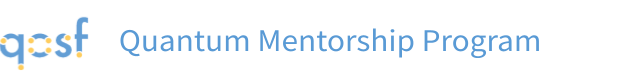

# Cohort 4 - Task 1 & Bonus

### Author: Lucas Arenstein


In this work I’m going to consider two differents solutions for the task 1 bonus problem, describe how they work, their implementation in Qiskit and compare these two solutions. The first solution uses a adapted qRAM and Grover Algorithm, and the second solution is based on Amplitude Amplification.

In the end I will comment about further work and a third solution that I'm currently working on.

##### Task 1:
_Design a general circuit that accepts vectors with random values of size 2n with m bits in length for each element and finds the state(s) indicated above from an oracle._



### Solution 1

#### Initial Setup
Let's first understand the circuit that solves this problem for the input [1,5,7,10] and later generalize it.

For this solution we need three quantum registers with the following number of qubits:

* A quantum register with 2 qubits for the indices of the $4 = 2^2$ elements.
* A quantum register with 4 qubits for the values of the input, note that we need at least 4 bits to represent the number 10 in binary.
* A quantum register for the output indices with 2 qubits for the indices and 1 ancilla for the Grover oracle.

The initial state of the first two registers is an equal superposition of the binary representation of the 4 integers of the input and their indices (starting from 00)


$$\ket{\psi} = \frac{1}{2}\big( 
\ket{\underbrace{0001}_{1}00} + \ket{\underbrace{0101}_{5}01}+
\ket{\underbrace{0111}_{7}10} + \ket{\underbrace{1010}_{10}11}\big)$$

and the initial state of the last register is $$\ket{\phi} = \ket{+ + -}.$$

We want to design a oracle that adds a negative phase to the index of the solutions states.
After that we are going to use Grover diffusion operator to increase the amplitudes of 
these states.


#### Oracle + qRam

Using a sequence of ($2 \cdot 2^2 = 8$) multi-controlled not gates we can find in which of the indices is the desired bitstring $010$ and $101$ in this case.

In the circuit bellow the first four gates will check and add a negative phase to the state that is represented by the bitstring $010$ and the last four gates will realize the same procedure to the state represented by $101$.

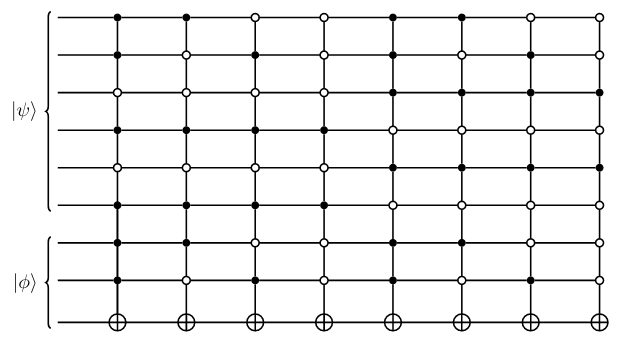

The $\LARGE \circ$ represent a anti-control (condition on qubit being on state $\ket{0}$),
the $\LARGE \bullet$ represent a control (condition on qubit being on state $\ket{1})$ and the $\oplus$ represent the NOT gate applied to the target qubit.


When we input the state vector $\ket{\psi} \otimes \ket{\phi}$ in this circuit the 1st multi-controlled not gate adds a negative phase to the state
$\ket{101011}\ket{- 1 1} $ and the 6th gate to the state $\ket{010101}\ket{-01}$.

#### Diffusion Operator

Now we want to increase the amplitudes of the solutions states. On the first 2 qubits of the third register we are going to apply the following circuit that is the standard Grover diffusion operator for 2 qubits and after that we are going to measure these qubits.



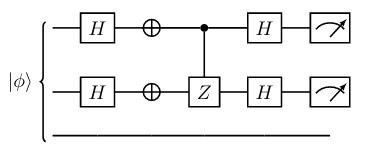

The two states with the highest amplitudes will correspond to the desired indices.

### Implementation

We are going to use the Qiskit programming language and introduce the functions following the same order as the subsections above.

In [121]:
import numpy as np, math
from qiskit import QuantumCircuit, execute, Aer
from qiskit.visualization import plot_histogram


In [122]:
#Input is the vector of integers
#Output state vector of the form ket{psi}
def initial_state(in_vector):
    
    #Check and get n
    n = len(in_vector)
    if n%2 != 0:
        print('Invalid Input - Vector must have size 2^n, with n>=2')
        return 0,0,0
    else: n = int(math.log(len(in_vector),2))
        
    #Find m
    m = len(np.binary_repr(max(in_vector)))
    
    #Binary vector with binary indices
    bi_vector_bi_index = [0]* 2**n
    
    #This vector will contain the integer values of the indices from the bi_vector_bi_index
    index_vector = [0]* 2**n

    for i in range(len(in_vector)):
        bi_vector_bi_index[i] = (str(np.binary_repr(in_vector[i],m)) + str(np.binary_repr(i,n)))
        index_vector[i] = int(bi_vector_bi_index[i],2)
 
    initial_state_vector = [0] * 2**(n+m)
    
    #Fill the initial_state_vector with amplitudes that respect
    #the normalization condition for each of the states of ket{psi}
    for i in index_vector:
        initial_state_vector[i] = 1/math.sqrt(len(index_vector))

    return initial_state_vector, n, m

In [123]:
input_vector = [1,5,7,10]
psi, n, m = initial_state(input_vector)
print(psi)

[0, 0, 0, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


If we convert the binary values of the states of $\ket{\psi}$ to their decimal representation we get

$$\ket{\psi}=\frac{1}{2}\big( 
\ket{\underbrace{0001}_{1}00} + \ket{\underbrace{0101}_{5}01}+
\ket{\underbrace{0111}_{7}10} + \ket{\underbrace{1010}_{10}11}\big) = 
\frac{1}{2} \big( \ket{4} + \ket{21} +\ket{30} +\ket{43}  \big)$$

and thats exactly the vector shown above.

With the values of $n$ and $m$ we can create our quantum circuit with the appropriate numbers of qubits and initialize the 3 registers.

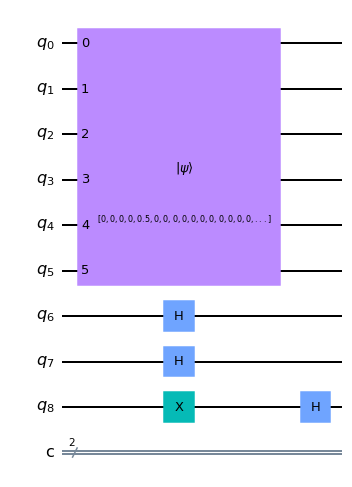

In [124]:
circuit = QuantumCircuit(m+n+n+1,n)

#First two registers
circuit.initialize(psi, list(range(n+m)))

#Third register ket{phi}
circuit.h(list(range(m+n,m+n+n)))
circuit.x(m+n+n)
circuit.h(m+n+n)
circuit.draw('mpl')

Now we are going to add the Oracle and qRAM to our circuit. 

Generalizing the circuit described in the Oracle + qRam section for a input with $2^n$ elements we need $2 \cdot 2^n$ multi-controlled not gates. Why is that ? Because for each one of the possible solutions (we always have two of them) we need to check the $2^n$ possible indices.

Qiskit doesn't have a native anti-control gate, so whenever we need this type of control on a qubit we are going to add a Not gate before using the MCX (multi-control Not) gate and uncompute this qubit to its original value with a final Not gate. 


In [125]:
def oracle_qram(n,m):
    #same size
    qc = QuantumCircuit(m+n+n+1,n)
    #There are always two solution
    #For each one of them we need 2^n multi-control not gates
    
    #Built the oracle
    for oracle in range(2):
        #oracle for 0101...
        if oracle == 0:
            for i in range(n, m+n, 2):
                qc.x(i)
        else:
            #oracle for 1010...
            for i in range(n+1, m+n, 2):
                qc.x(i)
        
        #This for loop runs twice for each one of the solutions
        for j in range(2**(n)):
            
            #For each one of the binary adds we built its MCX gate
            #using the appropriate oracle
            bi_add = np.binary_repr(j,n)
            #To list of integers
            l = [int(i) for i in list(bi_add)]
             
            #index of ones
            index_ones = [i for i, z in enumerate(l) if z == 1]
            
            #Index of ones for Grover (3rd register)
            index_ones_grover = [i+m+n for i in index_ones]
            
    
            if len(index_ones) != 0:
                #Nots for 1st and 3rd register
                qc.x(index_ones)
                qc.x(index_ones_grover)
                
                
            #Mult control not gate - target is the last qubit of the 3rd register
            qc.mcx(list(range(0,m+n+n)), m+n+n, mode='noancilla')
                
            #Uncompute
            if len(index_ones) != 0:
                qc.x(index_ones)
                qc.x(index_ones_grover)
        
        
        #Uncompute Oracle - just after the first 2^n indices
        if oracle == 0:
            for i in range(n, m+n, 2):
                qc.x(i)
        else:
            for i in range(n+1, m+n, 2):
                qc.x(i)
                 
    return qc

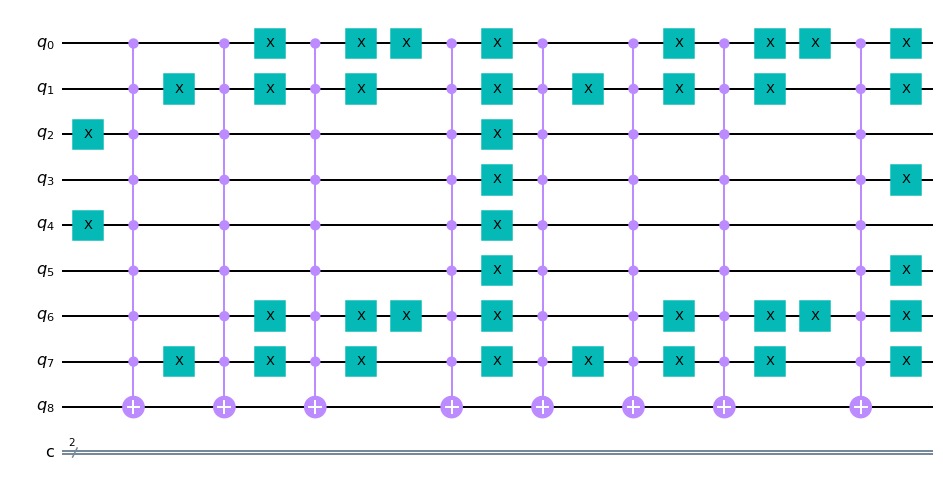

In [126]:
oracle_qram_circuit = oracle_qram(n,m)
oracle_qram_circuit.draw('mpl')

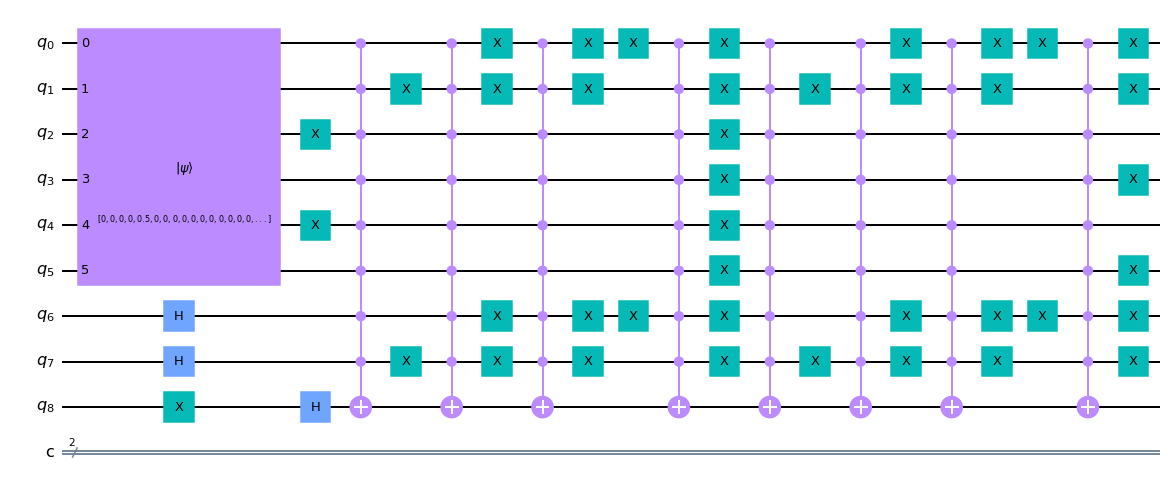

In [127]:
#Appending this oracle_qram circuit to our main
circuit.compose(oracle_qram_circuit, inplace=True)
circuit.draw('mpl')

Next we need to add the Grover diffusion operator on all qubits of the 3rd register except the last one. When we generalize this circuit for $n>2$ we are going to need multi-control Z gates that are not natively implemented in Qiskit. 

With a simple matrix multiplication we can verify that $HXH = Z$ and thats how we implement the Z gate on our circuit. Meaning that the multi control Z gate will became a sequence of Hadamard gates on the desired qubits follow by a multi control X gate (MCX) and than uncompute this qubits with the same sequence of Hadamard gates.

In [128]:
def grover_diffuser(n,m):
    #same size
    qc = QuantumCircuit(m+n+n+1,n)
    
    #first qubit of the 3rd register to start the diffuser
    #up until the last but one qubit
    for i in range(m+n,m+n+n):
        qc.h(i)
        qc.x(i)
    
    #Z = HXH
    #Multi-controlled Z gate equals H's Multi-controlled X gate H's
    qc.h(m+n+n-1)
    qc.mct(list(range(m+n,m+n+n-1)), m+n+n-1)
    qc.h(m+n+n-1)
    
    
    for i in range(m+n,m+n+n):
        qc.x(i)
        qc.h(i)
        
    return qc

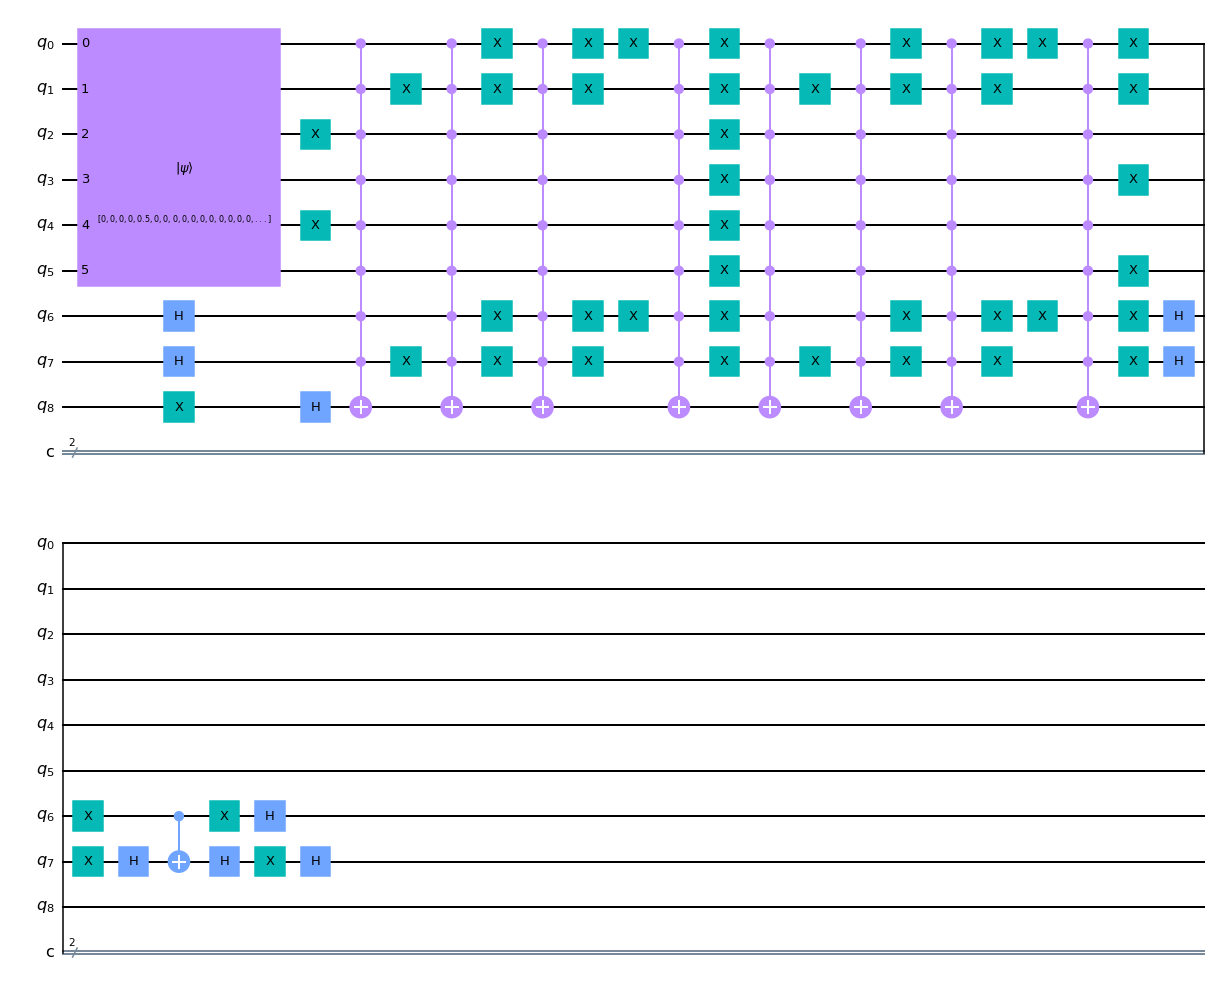

In [129]:
diffuser = grover_diffuser(n,m)
#Appending this diffuser circuit to our main
circuit.compose(diffuser, inplace=True)
circuit.draw('mpl')

The last part is to measure all the qubits from the 3rd register except the last one, and print the superposition of the two states with the highest amplitudes.

Solution for the input: [1, 5, 7, 10]


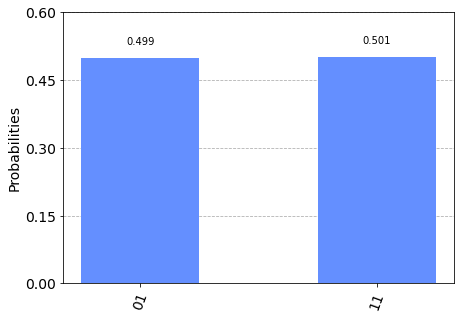

In [130]:
#Measuring
for i in range(n):
    circuit.measure(m+n+i,i)

backend = Aer.get_backend('statevector_simulator')
results = execute(circuit,backend).result().get_counts()

#Plot just the desired amplitudes
for i in range(0,(2**n - 2)):
    min_key = min(results.keys(), key=lambda k: results[k])
    del results[min_key]
    #To see all the amplitudes - just comment (#) in the for loop above
        
print("Solution for the input:", input_vector)
plot_histogram(results)



### Bonus

To run this circuit for any random input of size $2^n$ just call the function:

sol1_bonus$([i_1,i_2,..., i_{2^n}])$

where the input is a python list. 
For example sol1_bonus([1,5,7,10]) produce the result shown above.

In [131]:
def sol1_bonus(input_vector):
    
    in_vector = list(input_vector)
    
    initial_state_vector, n, m = initial_state(in_vector)
    if n == 0:
        return 
    
    circuit = QuantumCircuit(m+n+n+1,n)
    circuit.initialize(initial_state_vector, list(range(n+m)))
    
    #3rd Register Setup |++...+->
    #Hadamard for Grover
    circuit.h(list(range(m+n,m+n+n)))
    
    circuit.x(m+n+n)
    circuit.h(m+n+n)

    oracle_qram_circuit = oracle_qram(n,m)
    
    circuit.compose(oracle_qram_circuit, inplace=True)
    
    diffuser = grover_diffuser(n,m)
   
    circuit.compose(diffuser, inplace=True)

    #Measuring
    for i in range(n):
        circuit.measure(m+n+i,i)

    backend = Aer.get_backend('statevector_simulator')
    results = execute(circuit,backend).result().get_counts()

    #Plot just the desired amplitudes
    for i in range(0,(2**n - 2)):
        min_key = min(results.keys(), key=lambda k: results[k]) 
        del results[min_key]
    #To see all the amplitudes - just comment (#) in the for loop above

    #print("Solution for the input:", input_vector)

    return plot_histogram(results)

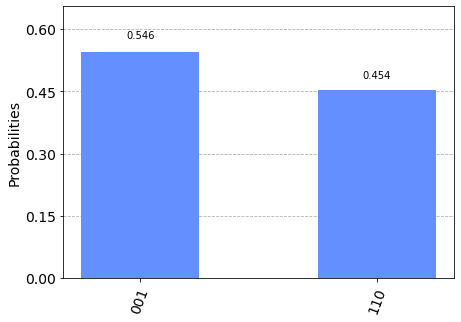

In [132]:
#Indices Starting from 0 to 7, n=3, m=4
#index of 0101 (5) is 110 and index of 1010 (10) in binary 001
sol1_bonus([7,10,1,11,0,2,5,4])


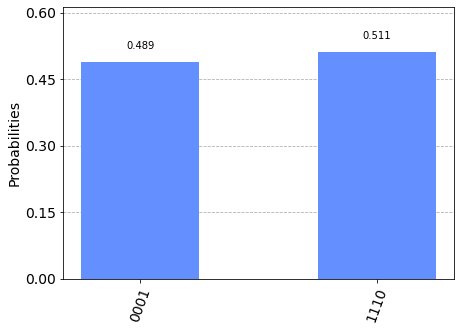

In [133]:
#Indices Starting from 0 to 15, n=4, m=5
#index of 01010 (10) is 0001 and index of 10101 (21) in binary 1110

sol1_bonus([0,10,30,2,17,15,8,4,31,11,24,13,12,29,21,1])

In [134]:
#Feel free to try any values you like :D 

#sol1_bonus([insert_you_list])

#### Final Remarks of Solution 1

For solution 1 we need $\underbrace{n+m}_{\text{input}} + \underbrace{n+1}_{\text{ancilla}} = 2n+m+1$ qubits.

### Solution 2

##### Motivation
After Solution 1 I start to wonder:

Is it possible to design another type of quantum circuit that uses fewer qubits? 
Ideally just the $n + m$ qubits necessary to specify the problem ?

Using a small modification on the amplitude amplification algorithm I managed to achieve this lower bound on the numbers of qubits.

We usually use the amplitude amplification algorithm to go from the initial state $\ket{\psi_i}$ (generated by the input) to the target state $\ket{\psi_t}$.


##### A bit of math

Lets formally define the states of our algorithm as we would on the general amplitude amplification algorithm and later adapt to our need.

* $V$ is the input vector $v_j \in V$, where $0 \leq j \leq 2^n - 1$ and $m$ is the minimum number of bits to express any $v_j$.



* $\ket{\psi_i}$ is the initial state generated classicaly from $V$

$$\ket{\psi_i} = \frac{1}{\sqrt{2^n}} \Big( \sum_{j=0}^{2^n - 1} \ket{v_j j_b} \Big)$$ 

$~~~~~~~$where $j_b$ is the binary representation of $j$ with $m$ digits.

* $\ket{\psi_t}$ is the target state, that is a uniform superposition of all the possible solutions, $2$ valid bitstrings $s_1$ and $s_2$ each one with $2^n$ possible indices

$$\ket{\psi_t} = \frac{1}{\sqrt{2^{n+1}}} \Big( \sum_{k=0}^{2^n - 1}\big( \ket{s_1 k_b} + \ket{s_2 k_b}\big) \Big)$$

$~~~~~~~$where $k_b$ is the binary representation of $k$ with $m$ digits
and $s_1 = \underbrace{0101...01}_{m \text{ digits}}$ and $s_2 = \underbrace{1010...10}_{m \text{ digits}}$





To familiarize the reader with this notation, using the input [1,5,7,10] as an example the initial state is

$$\ket{\psi_i}=\frac{1}{2}( 
\ket{\underbrace{0001}_{1}00} + \ket{\underbrace{0101}_{5}01}+
\ket{\underbrace{0111}_{7}10} + \ket{\underbrace{1010}_{10}11}$$

and the target state is 
$$\ket{\psi_t} = \frac{1}{2\sqrt{2}} \big(
\ket{010100} + \ket{010101} + \ket{010110} + \ket{010111} +
\ket{101000} +\ket{101001} +\ket{101010} +\ket{101011}\big)$$

##### General Amplitude Amplification Algorithm

In the general amplitude amplification algorithm we go from the initial state to the target state via repeated application of the reflection operator $R = -S_t S_i$ where

$$S_i = 2 \ket{\psi_i} \bra{\psi_i} - I$$
$$S_t = 2 \ket{\psi_t} \bra{\psi_t} - I$$

on the initial state $\ket{\psi_i}$. 

Meaning that on the general case $R^k \ket{\psi_i}$ will get closer to $\ket{\psi_t}$ as $k$ get larger.

##### Adapted Amplitude Amplification Algorithm
In our case we don't want to get closer to $\ket{\psi_t}$, we want to get closer to $\ket{\psi'_t}$ 

$$\ket{\psi'_t} = \alpha \ket{s_1 j_{b_1}} + \beta \ket{s_2 j_{b_2}} + \sum_l \gamma_l \ket{others}$$

where $|\alpha|^2 + |\beta|^2 + |\gamma|^2 = 1 $, $j_{b_1}$ and $j_{b_2}$ are the binary index of $s_1$ and $s_2$ our desired solution. This algorithm is not exact $\ket{\psi'_t}$ will be a superposition of other states as well that are represented by the summation on the right hand side.

##### How to get from $\ket{\psi_i}$ to $\ket{\psi'_t}$ ? 

After a bit of numerical analysis we found out that applying $R^k$ where $k = 2^n$ on the initial state $\ket{\psi_i}$ we get to the target state $\ket{\psi'_t}$ with $\alpha$ and $\beta$ being the two highest amplitudes in this state.

##### Why not use the reflection $S_t = 2 \ket{\psi'_t} \bra{\psi'_t} - I$ ?

That would be cheating wouldn't it ? 
Classicaly calculating the vector $\ket{\psi'_t}$ would require to find the answer of the problem and thats exactly what we are looking to do, but on a quantum computer.

##### Qiskit Implementation of this algorithm

In the last subsections we described mathematically how this adapted amplitude amplification algorithm works, bellow is the circuit representation that we are going to implement in Qiskit.

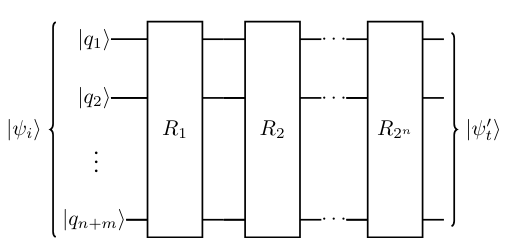

We are going to use the same function *initial_state()* from Solution 1 to generate $\ket{\psi_i}$.

To generate the state $\ket{\psi_t}$ we have the following function:

In [135]:
def target_state(n,m):
    s1 = ['0']*(m)
    s2 = ['1']*(m)
    for i in range(1,m,2):
        s1[i] = '1'
        s2[i] = '0'

    #0101...00    
    first_index_s1 = int((''.join(s1) + ''.join(['0']*n)),2)
    #1010...00
    first_index_s2 = int((''.join(s2) + ''.join(['0']*n)),2)
    
    #Calculating the index of each one of the state of \ket{\psi_t} 
    l_index = [0]*2**(n+1)
    l_index[0] = first_index_s1
    l_index[2**n] = first_index_s2
    
    #first half: |s_1 00..00> |s_1 00..01>,..., |s_1 11..111>
    #second half: |s_2 00..00> |s_2 00..01>,..., |s_2 11..111>
    
    for i in range(1,2**n):
        l_index[i] = l_index[i-1] + 1
        l_index[i+2**n] =l_index[(i-1)+2**n] + 1
    
    
    psi_t = [0] * 2 **(m+n)
    
    for i in l_index:
        psi_t[i] = 1/math.sqrt(len(l_index))
    
    return psi_t

Next we have a function that builds reflections operator of the form $2\ket{v}\bra{v} - I$ that we are going to use to generate the matrices $S_i$ and $S_t$.

In [136]:
def build_reflection(vector):
    row = np.array(vector)
    col = row.transpose()
    #Identity matrix with the appropriate size
    S = (2*(np.outer(col,row))) - np.identity(len(vector))
    
    return S

The function _sol2_bonus(input_vector)_ implement this adapted amplitude amplification algorithm to any input and plot the histogram of the desired answer.

In [137]:
def sol2_bonus(input_vector):
    in_vector = list(input_vector)
    
    psi_i, n, m = initial_state(in_vector)
    if n == 0:
        return 
    
    psi_t = target_state(n,m)
    
    #Building S_i and S_t and calculate R
    S_i = build_reflection(psi_i)
    
    S_t = build_reflection(psi_t)
    
    R = - np.matmul(S_t,S_i)
    
    qc = QuantumCircuit(n+m,n)
    
    qc.initialize(psi_i, list(range(m+n)))
    
    #Number of iterations to apply R onto \ket{\psi_i}
    for i in range(2**n):
        qc.unitary(R, list(range(m+n)), label='R')

    for i in range(n):
        qc.measure(i,i)
    
    backend = Aer.get_backend('statevector_simulator')
    results = execute(qc,backend).result().get_counts()

    #Plot just the desired amplitudes
    for i in range(0,(2**n - 2)):
        min_key = min(results.keys(), key=lambda k: results[k]) 
        del results[min_key]
    #To see all the amplitudes - just comment (#) in the for loop above
    
    return plot_histogram(results)

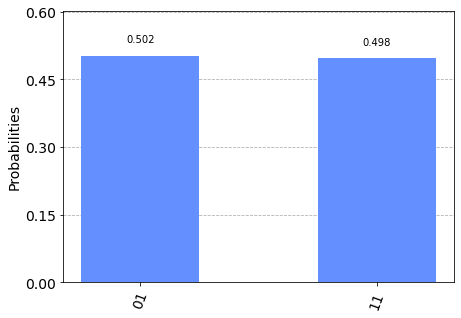

In [138]:
#Lets run for the input [1,5,7,10]
input_vector = [1,5,7,10] 
sol2_bonus(input_vector)


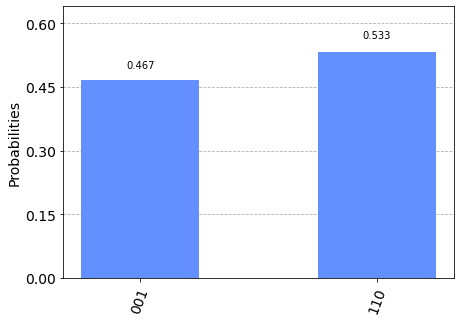

In [139]:
#Indices Starting from 0 to 7, n=3, m=4
#index of 0101 (5) is 110 and index of 1010 (10) in binary 001
sol2_bonus([7,10,1,11,0,2,5,4])

## Comparing Solutions 1 and 2

##### Number of qubits
For solution 1 we need $\underbrace{n+m}_{\text{input}} + \underbrace{n+1}_{\text{ancilla}} = 2n+m+1$ qubits and for solution 2 we need just $n+m$ qubits.

##### Time and Gates
It is easy to see that solution 1 needs $2 \cdot 2^n = 2^{n+1}$ gates, but what about solution 2 ?

Every one of the $k=2^n$ iterations of solution 2, involves multiplying the vector state by a square matrix of dimension $2^{n+m}$. For each iteration qiskit decomposes this huge matrix into a circuit, this operation is extremely costly. To prove my point look at the time each one of the solutions took to solve the same input of the problem.



The following tests were run on Ubuntu with 4GB of ram and 2.3GHz processor

In [140]:
input_vector = [7,10,1,11,0,2,5,4] 
print('Comparing Solutions for the input', input_vector)

Comparing Solutions for the input [7, 10, 1, 11, 0, 2, 5, 4]


In [141]:
print('Avg Time Solution 1 for', input_vector)
%timeit sol1_bonus(input_vector)

Avg Time Solution 1 for [7, 10, 1, 11, 0, 2, 5, 4]
788 ms ± 12.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [142]:
print('Avg Time Solution 2 for', input_vector)
%timeit sol2_bonus(input_vector)

Avg Time Solution 2 for [7, 10, 1, 11, 0, 2, 5, 4]
874 ms ± 55.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Not much of a diference for $n=3$ and $m=4$.

Lets try for $n=4$ and $m=4$

In [116]:
input_vector = [0,13,1,7,15,2,11,3,1,4,14,5,6,12,8,9]

In [119]:
#Warning this will take more than 20 seconds to run
#Spoiler if you dont want to wait this takes about 3.21 ± 19.8ms per loop
print('Avg Time Solution 1 for', input_vector)
%timeit sol1_bonus(input_vector)

Avg Time Solution 1 for [0, 13, 1, 7, 15, 2, 11, 3, 1, 4, 14, 5, 6, 12, 8, 9]
3.21 s ± 19.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [118]:
#Warning this will take more than 3 minutes to run
#Spoiler if you dont want to wait this takes about 23.7 s ± 164ms per loop
print('Avg Time Solution 2 for', input_vector)
%timeit sol2_bonus(input_vector)

Avg Time Solution 2 for [0, 13, 1, 7, 15, 2, 11, 3, 1, 4, 14, 5, 6, 12, 8, 9]
23.7 s ± 164 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Solution 2 took almost 8 times more than solution 1 for a relatively small input.

We can conclude that the time complexity of solution 1 is much better than solution 2.

## Further work

##### Solution 1
1. Is there any other more efficient way to build an oracle ?

##### Solution 2
2. Research more efficient implementations of the reflections operators
      
      2.1 Is there an algorithm to decompose this reflections as a circuit for any input?

##### Solution 3
3. Design an algorithm that uses the same input as solution 2, that is n + m qubits but is more efficient than solution 1

I'm currently working on solution 3 but unfortunately I ran out of time.

### Extra part - Solution 3 - work in progress

I'm still working on how to design the following circuit

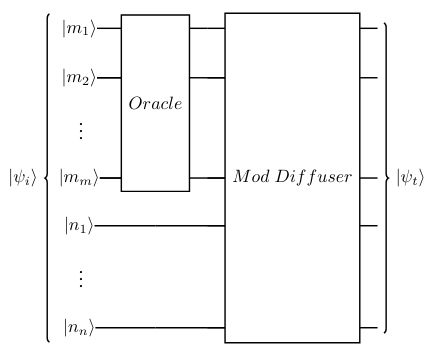

$\ket{\psi_i}$ is the initial state as definied in section 2. 

The oracle ($O_r$) is a circuit of the form:

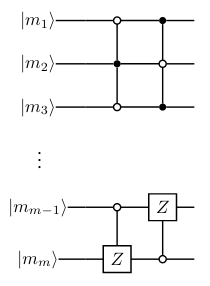

That flips the amplitude of the states that satisfy the criterion.

Using the same notations from solution 2

$$\ket{\psi_i} = \frac{1}{\sqrt{2^n}} \Big( \sum_{j=0}^{2^n - 1} \ket{v_j j_b} \Big)$$ 

$$O_r \ket{\psi_i} = \frac{1}{\sqrt{2^n}} \Big( \sum_{\substack{j=0\\ j \neq j_{s1} \\ j \neq j_{s2}}}^{2^n - 1} \ket{v_j j_b} - \ket{v_{s1} j_{s1}} - \ket{v_{s2} j_{s2}} \Big)$$


### To do

Think and implement a diffuser operator $D$, ideally some operator that is easily build using elementary gates that when applied to the state $O_r \ket{\psi_i}$ will amplify the amplitudes of the states with a negative phase.

$$D (O_r \ket{\psi_i}) \approx \frac{1}{\sqrt{2}} (\pm \ket{v_{s1} j_{s1}} \pm \ket{v_{s2} j_{s2}})$$

#### Why Grover diffuser operator doesn't work  in this case?

Because the diffuser used in Grover algorithm as in solution 1, just work when applied to an equal superposition of all the base states of the system. 

#### Some references on this question:
https://quantumcomputing.stackexchange.com/questions/15766/why-does-grovers-algorithm-reflect-along-000-0-rangle/15838#15838

https://quantumcomputing.stackexchange.com/questions/4397/why-does-grovers-search-invert-about-the-mean




### References:
1. Quantum random access memory-
   Vittorio Giovannetti, Seth Lloyd, Lorenzo Maccone
   https://arxiv.org/abs/0708.1879
   
2. A primer on quantum RAM - Olivia Di Matteo
   https://github.com/qsharp-community/qram/blob/master/docs/primer.pdf
   
3. A fast quantum mechanical algorithm for database search - Lov K. Grover
   https://arxiv.org/abs/quant-ph/9605043
 
4. Quantum Amplitude Amplification and Estimation - 
   Gilles Brassard, Peter Hoyer, Michele Mosca, Alain Tapp

5. [Book] Quantum computation and quantum information - Michael A. Nielsen, Isaac Chuang 

6. Qiskit: An Open-source Framework for Quantum Computing
    